In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-homework3/shakespeare_train.txt
/kaggle/input/dl-homework3/shakespeare_valid.txt


## 0.Preprocessing of Text 

In [2]:
import torch
import torch.nn.functional as F
import io

# load data
data_URL = '/kaggle/input/dl-homework3/shakespeare_train.txt' 
with io.open(data_URL, 'r', encoding='utf8') as f: 
    text = f.read() 

# Characters' collection 
vocab = set(text) 

# Construct character dictionary 
vocab_to_int = {c: i for i, c in enumerate(vocab)} 
int_to_vocab = dict(enumerate(vocab)) 
# Encode data, shape = [number of characters] (index ,still not one-hot)
train_data = np.array([vocab_to_int[c] for c in text], dtype=np.int32) 

## 1. Construct a standard RNN then show your (1) network architecture, (2) learning curve, (3) training error rate and (4) validation error rate.

In [3]:
vocab_size = len(vocab)
print(len(train_data), vocab_size)

4351312 67


### (1) network architecture

#### (1.1) Construct the dataset

- Construct the dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        """
        data: 1D numpy array
        seq_len: the sequence len of each sample
        """
        self.data = torch.from_numpy(data).long()  # [N]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        # input:  [t_i, ..., t_{i+seq_len-1}]
        # target: [t_{i+1}, ..., t_{i+seq_len}]
        x = self.data[idx : idx + self.seq_len]          # [seq_len]
        y = self.data[idx + 1 : idx + self.seq_len + 1]  # [seq_len]
        return x, y

- Split to training set (90%) and validation set (10%)

In [7]:
seq_len = 100
batch_size = 64

N = len(train_data)
split_idx = int(0.9 * N) #train/val
train_array = train_data[:split_idx]
val_array   = train_data[split_idx:]

train_dataset = CharDataset(train_array, seq_len)
val_dataset   = CharDataset(val_array, seq_len)

#data loader
train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False
)

#### (1.2) Construct a standard RNN w/ one-hot input

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNNOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=vocab_size,   # one-hot dim
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        # hidden: vocab logits
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x_onehot, h0=None):

        out, h_n = self.rnn(x_onehot, h0)   # [batch, seq, hidden]
        logits = self.fc(out)               # [batch, seq, vocab]
        return logits, h_n

#### (1.3) Training Loop (record BPC and error rate simultaneously)
- We compute BPC using CrossEntropyLoss(CE) because BPC is mathematically equivalent to the cross-entropy (in natural log) divided by ln(2). CrossEntropyLoss in PyTorch uses natural logarithms, while BPC uses log base 2
- CE:
$$
\text{CE} = -\frac{1}{T} \sum_{t=1}^{T} \log y_{t, y_t}
$$

- BPC:
$$
\text{BPC} = -\frac{1}{T} \sum_{t=1}^{T} \sum_{k=1}^{K} t_{t,k} \log_{2} y_{t,k} = -\frac{1}{T} \sum_{t=1}^{T} \log_{2} y_{t, y_t}
$$

- In conclusion,
$$
\text{BPC} = \frac{CE}{ln2}
$$

We can say that minimizing CE is equivalent to minimizing BPC

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 128
num_layers = 1 # standard RNN
num_epochs = 15
lr = 1e-3

model = CharRNNOneHot(vocab_size, hidden_size, num_layers).to(device)

# Cross Entropy Loss
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# BPC initial
train_bpcs = []
val_bpcs = []

# Error initial
train_errors = []
val_errors = []

for epoch in range(1, num_epochs + 1):
    
    # ---------- Train ----------
    model.train()
    total_bpc = 0.0
    total_tokens = 0
    total_correct = 0

    for x, y in train_loader:
        # operate in GPU P100
        x = x.to(device)
        y = y.to(device)

        x_onehot = F.one_hot(x, num_classes=vocab_size).float()

        # Initialize hidden state: 0
        h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)

        logits, h_n = model(x_onehot, h0)  # [B, T, V]

        # CE loss
        ce_loss = criterion(
            logits.view(-1, vocab_size),
            y.view(-1)                   
        )

        # CE loss to BPC
        bpc = ce_loss / math.log(2.0)

        optimizer.zero_grad()
        bpc.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) #avoid exploding gradient
        optimizer.step()

        num_tokens = x.numel()   # B*T
        total_bpc += bpc.item() * num_tokens
        total_tokens += num_tokens

        # Accuracy
        with torch.no_grad():
            pred = logits.argmax(dim=-1)
            total_correct += (pred == y).sum().item()

    # Avg BPC
    avg_train_bpc = total_bpc / total_tokens
    train_acc = total_correct / total_tokens
    train_error = 1.0 - train_acc

    train_bpcs.append(avg_train_bpc)
    train_errors.append(train_error)

    checkpoint_epochs = [1, 4, 8, 12, 15]

    if epoch in checkpoint_epochs:
        torch.save(model.state_dict(), f"rnn_epoch{epoch}.pth")

    # ---------- Validation ----------
    model.eval()
    val_total_bpc = 0.0
    val_total_tokens = 0
    val_total_correct = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            x_onehot = F.one_hot(x, num_classes=vocab_size).float()
            h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)

            logits, h_n = model(x_onehot, h0)

            ce_loss = criterion(
                logits.view(-1, vocab_size),
                y.view(-1)
            )
            bpc = ce_loss / math.log(2.0)

            num_tokens = x.numel()
            val_total_bpc += bpc.item() * num_tokens
            val_total_tokens += num_tokens

            pred = logits.argmax(dim=-1)
            val_total_correct += (pred == y).sum().item()

    avg_val_bpc = val_total_bpc / val_total_tokens
    val_acc = val_total_correct / val_total_tokens
    val_error = 1.0 - val_acc

    val_bpcs.append(avg_val_bpc)
    val_errors.append(val_error)

    print(f"Epoch {epoch:02d} | "
          f"Train BPC {avg_train_bpc:.4f}, Error {train_error:.4f} | "
          f"Val BPC {avg_val_bpc:.4f}, Error {val_error:.4f}")


Epoch 01 | Train BPC 2.2960, Error 0.4758 | Val BPC 2.3602, Error 0.4805
Epoch 02 | Train BPC 2.1693, Error 0.4545 | Val BPC 2.3487, Error 0.4759
Epoch 03 | Train BPC 2.1512, Error 0.4514 | Val BPC 2.3452, Error 0.4749
Epoch 04 | Train BPC 2.1429, Error 0.4501 | Val BPC 2.3430, Error 0.4729
Epoch 05 | Train BPC 2.1378, Error 0.4492 | Val BPC 2.3416, Error 0.4714
Epoch 06 | Train BPC 2.1345, Error 0.4487 | Val BPC 2.3421, Error 0.4709
Epoch 07 | Train BPC 2.1325, Error 0.4483 | Val BPC 2.3478, Error 0.4716
Epoch 08 | Train BPC 2.1311, Error 0.4480 | Val BPC 2.3502, Error 0.4711
Epoch 09 | Train BPC 2.1299, Error 0.4479 | Val BPC 2.3588, Error 0.4718
Epoch 10 | Train BPC 2.1290, Error 0.4478 | Val BPC 2.3580, Error 0.4706
Epoch 11 | Train BPC 2.1281, Error 0.4476 | Val BPC 2.3695, Error 0.4712
Epoch 12 | Train BPC 2.1274, Error 0.4474 | Val BPC 2.3674, Error 0.4716
Epoch 13 | Train BPC 2.1269, Error 0.4473 | Val BPC 2.3649, Error 0.4728
Epoch 14 | Train BPC 2.1266, Error 0.4472 | Val BPC

### (2) learning curve

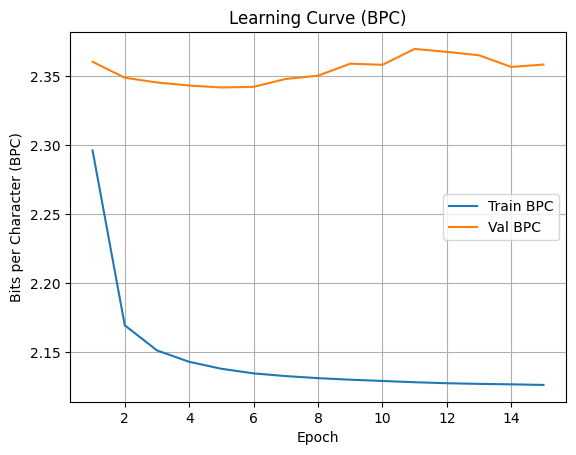

In [9]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_bpcs, label="Train BPC")
plt.plot(epochs, val_bpcs, label="Val BPC")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Learning Curve (BPC)")
plt.legend()
plt.grid(True)
plt.show()

### (3) training error rate

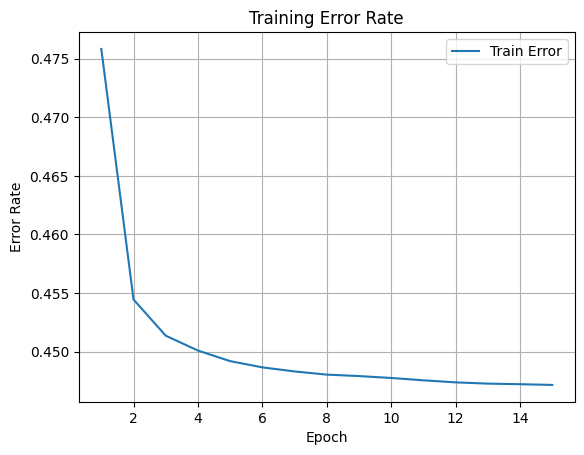

In [10]:
plt.figure()
plt.plot(epochs, train_errors, label="Train Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Training Error Rate")
plt.legend()
plt.grid(True)
plt.show()

### (4) validation error rate

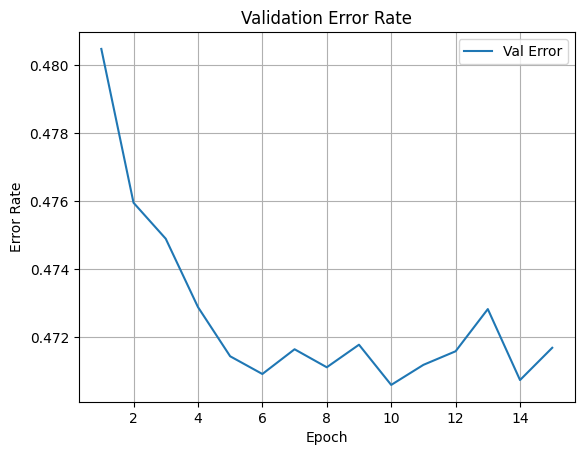

In [11]:
plt.figure()
plt.plot(epochs, val_errors, label="Val Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Validation Error Rate")
plt.legend()
plt.grid(True)
plt.show()


## 2. Choose 5 breakpoints during your training process to show how well your network learns through more epochs. Feed some part of your training text into RNN and show the text output.

### 2.1 Define the generative test function

In [14]:
def generate_text(model, start_text, gen_len=300):
    model.eval()
    generated = list(start_text)

    # Initialize hidden state
    h = torch.zeros(num_layers, 1, hidden_size).to(device)

    # "prime_text" into RNN
    input_idx = torch.tensor([[vocab_to_int[c] for c in start_text]], device=device)
    x_onehot = F.one_hot(input_idx, num_classes=vocab_size).float()
    with torch.no_grad():
        _, h = model(x_onehot, h)

    # generate from the last token to the first
    idx = input_idx[0, -1].item()

    for _ in range(gen_len):
        x = torch.tensor([[idx]], device=device)
        x_onehot = F.one_hot(x, num_classes=vocab_size).float()

        with torch.no_grad():
            logits, h = model(x_onehot, h)

        # greedy pick
        idx = int(torch.argmax(logits[0, -1]).item())
        generated.append(int_to_vocab[idx])

    return "".join(generated)

### 2.2 Feed some part of training text (I use line29 ~ line39 in `shakespeare_train.txt`) to RNN, and show the text output

In [13]:
prime_text = "ROMEO:"

In [14]:
for e in [1, 4, 8, 12, 15]:
    ckpt = f"rnn_epoch{e}.pth"
    model = CharRNNOneHot(vocab_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))

    print(f"\n===== Epoch {e} Output =====")
    print(generate_text(model, prime_text, gen_len=300))


===== Epoch 1 Output =====
ROMEO:
The shall be so shall be so shall be so shall be some to me to the world with the seat and soul and the good soul and the world to the seat and soul and the good soul and the world to the seat and soul and the good soul and the world to the seat and soul and the good soul and the world to the seat 

===== Epoch 4 Output =====
ROMEO:
The world the more that we will be the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the stran

===== Epoch 8 Output =====
ROMEO:
Here is the strange the strange the strange to the strange to the strangers and the strange to the strangers and the strange to the strangers and the strange to the strangers and the strange to the strangers and the strange to the strangers and the strange to the strangers and the strange to th

## 3. Compare the results of choosing different sizes of hidden states and sequence length by plotting the training loss vs. different parameters.

### 0. Define the RNN function in Question 1 in order to tidy up the code in this question

In [15]:
def train_rnn(hidden_size, seq_len, batch_size=64, num_layers=1, num_epochs=15, lr=1e-3):
    train_dataset = CharDataset(train_array, seq_len)
    val_dataset   = CharDataset(val_array, seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CharRNNOneHot(vocab_size, hidden_size, num_layers).to(device)
    
    # Cross Entropy Loss
    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # BPC initial
    train_bpcs = []
    val_bpcs = []
    
    # Error initial
    train_errors = []
    val_errors = []
    
    for epoch in range(1, num_epochs + 1):
        
        # ---------- Train ----------
        model.train()
        total_bpc = 0.0
        total_tokens = 0
        total_correct = 0
    
        for x, y in train_loader:
            # operate in GPU P100
            x = x.to(device)
            y = y.to(device)
    
            x_onehot = F.one_hot(x, num_classes=vocab_size).float()
    
            # Initialize hidden state: 0
            h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
    
            logits, h_n = model(x_onehot, h0)  # [B, T, V]
    
            # CE loss
            ce_loss = criterion(
                logits.view(-1, vocab_size),
                y.view(-1)                   
            )
    
            # CE loss to BPC
            bpc = ce_loss / math.log(2.0)
    
            optimizer.zero_grad()
            bpc.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) #avoid exploding gradient
            optimizer.step()
    
            num_tokens = x.numel()   # B*T
            total_bpc += bpc.item() * num_tokens
            total_tokens += num_tokens
    
            # Accuracy
            with torch.no_grad():
                pred = logits.argmax(dim=-1)
                total_correct += (pred == y).sum().item()
    
        # Avg BPC
        avg_train_bpc = total_bpc / total_tokens
        train_acc = total_correct / total_tokens
        train_error = 1.0 - train_acc
    
        train_bpcs.append(avg_train_bpc)
        train_errors.append(train_error)
        # ---------- Validation ----------
        model.eval()
        val_total_bpc = 0.0
        val_total_tokens = 0
        val_total_correct = 0
    
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
    
                x_onehot = F.one_hot(x, num_classes=vocab_size).float()
                h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
    
                logits, h_n = model(x_onehot, h0)
    
                ce_loss = criterion(
                    logits.view(-1, vocab_size),
                    y.view(-1)
                )
                bpc = ce_loss / math.log(2.0)
    
                num_tokens = x.numel()
                val_total_bpc += bpc.item() * num_tokens
                val_total_tokens += num_tokens
    
                pred = logits.argmax(dim=-1)
                val_total_correct += (pred == y).sum().item()
    
        avg_val_bpc = val_total_bpc / val_total_tokens
        val_acc = val_total_correct / val_total_tokens
        val_error = 1.0 - val_acc
    
        val_bpcs.append(avg_val_bpc)
        val_errors.append(val_error)
    
        print(f"Epoch {epoch:02d} | "
              f"Train BPC {avg_train_bpc:.4f}, Error {train_error:.4f} | "
              f"Val BPC {avg_val_bpc:.4f}, Error {val_error:.4f}")
    return train_bpcs, val_bpcs, train_errors, val_errors, model



### Case 1: Fix sequence length, and change the hidden state to **64**

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# hidden size: 64
train_bpcs_64, val_bpcs_64, _, _, _ = train_rnn(hidden_size=64, seq_len=100)

Epoch 01 | Train BPC 2.5451, Error 0.5190 | Val BPC 2.5766, Error 0.5219
Epoch 02 | Train BPC 2.4479, Error 0.5006 | Val BPC 2.5776, Error 0.5176
Epoch 03 | Train BPC 2.4346, Error 0.4986 | Val BPC 2.5776, Error 0.5184
Epoch 04 | Train BPC 2.4289, Error 0.4980 | Val BPC 2.5836, Error 0.5171
Epoch 05 | Train BPC 2.4258, Error 0.4975 | Val BPC 2.5841, Error 0.5160
Epoch 06 | Train BPC 2.4241, Error 0.4970 | Val BPC 2.5869, Error 0.5161
Epoch 07 | Train BPC 2.4227, Error 0.4967 | Val BPC 2.5835, Error 0.5147
Epoch 08 | Train BPC 2.4215, Error 0.4965 | Val BPC 2.5854, Error 0.5151
Epoch 09 | Train BPC 2.4207, Error 0.4962 | Val BPC 2.5825, Error 0.5150
Epoch 10 | Train BPC 2.4199, Error 0.4959 | Val BPC 2.5870, Error 0.5139
Epoch 11 | Train BPC 2.4193, Error 0.4957 | Val BPC 2.5847, Error 0.5151
Epoch 12 | Train BPC 2.4187, Error 0.4956 | Val BPC 2.5868, Error 0.5145
Epoch 13 | Train BPC 2.4183, Error 0.4956 | Val BPC 2.5932, Error 0.5156
Epoch 14 | Train BPC 2.4178, Error 0.4954 | Val BPC

In [ ]:
# hidden size: 128 (original)
train_bpcs_128, val_bpcs_128, _, _, _ = train_rnn(hidden_size=128, seq_len=100)

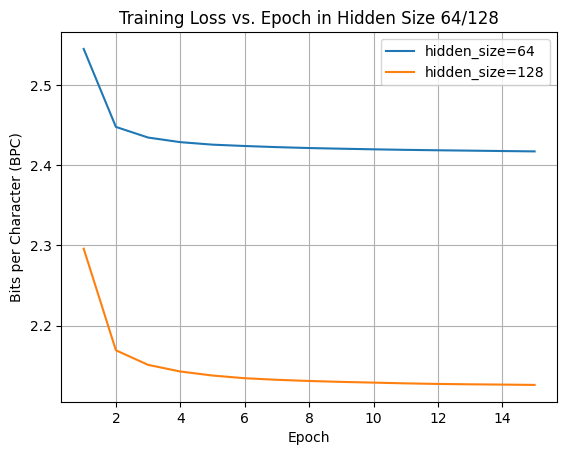

In [17]:
#Compare with hidden size: 64/128
epochs = range(1, 16)

plt.figure()
plt.plot(epochs, train_bpcs_64,  label="hidden_size=64")
plt.plot(epochs, train_bpcs_128, label="hidden_size=128")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Training Loss vs. Epoch in Hidden Size 64/128")
plt.legend()
plt.grid(True)
plt.show()

- As the result, BPC in `hidden_size=64` converges to about 2.42 ; BPC in `hidden_size=128` converges to about 2.13
- We can speculate **a larger hidden size leads to a lower BPC** because the hidden state dimension controls the model capacity.

### Case 2: Fix the hidden size, and change the Sequence length to **50**

In [18]:
# sequence length: 50
train_bpcs_50, val_bpcs_50, _, _, _ = train_rnn(hidden_size=128, seq_len=50)

Epoch 01 | Train BPC 2.3646, Error 0.4892 | Val BPC 2.3966, Error 0.4906
Epoch 02 | Train BPC 2.2339, Error 0.4674 | Val BPC 2.3816, Error 0.4859
Epoch 03 | Train BPC 2.2131, Error 0.4637 | Val BPC 2.3750, Error 0.4843
Epoch 04 | Train BPC 2.2033, Error 0.4620 | Val BPC 2.3723, Error 0.4820
Epoch 05 | Train BPC 2.1976, Error 0.4611 | Val BPC 2.3674, Error 0.4824
Epoch 06 | Train BPC 2.1938, Error 0.4603 | Val BPC 2.3706, Error 0.4825
Epoch 07 | Train BPC 2.1909, Error 0.4597 | Val BPC 2.3688, Error 0.4816
Epoch 08 | Train BPC 2.1885, Error 0.4592 | Val BPC 2.3715, Error 0.4827
Epoch 09 | Train BPC 2.1866, Error 0.4590 | Val BPC 2.3684, Error 0.4818
Epoch 10 | Train BPC 2.1851, Error 0.4587 | Val BPC 2.3674, Error 0.4809
Epoch 11 | Train BPC 2.1840, Error 0.4584 | Val BPC 2.3745, Error 0.4819
Epoch 12 | Train BPC 2.1831, Error 0.4582 | Val BPC 2.3739, Error 0.4809
Epoch 13 | Train BPC 2.1826, Error 0.4580 | Val BPC 2.3710, Error 0.4793
Epoch 14 | Train BPC 2.1822, Error 0.4579 | Val BPC

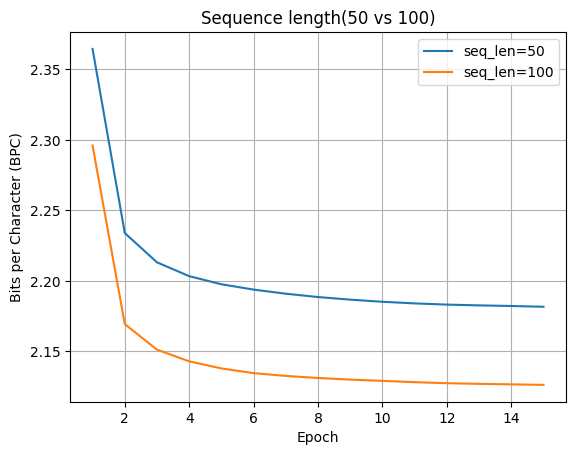

In [19]:
# Compare with seq_len: 50/100
epochs = range(1, 16)

plt.figure()
plt.plot(epochs, train_bpcs_50,  label="seq_len=50")
plt.plot(epochs, train_bpcs_128, label="seq_len=100")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Sequence length(50 vs 100)")
plt.legend()
plt.grid(True)
plt.show()

- As the result, BPC in `seq_len=50` converges to around 2.18 ; BPC in `seq_len=100` converges to around 2.13
- This shows that **using longer context windows allows the RNN to learn more** useful dependencies in the text.

## 4. Construct another RNN with LSTM then redo 1. to 3. Also discuss the difference of the results between standard RNN and LSTM.

### (1) network architecture (RNN w/ LSTM)

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CharLSTMOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        # hidden → vocab logits
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x_onehot, h0=None, c0=None):

        if h0 is None or c0 is None:
            out, (h_n, c_n) = self.rnn(x_onehot) #initialize
        else:
            out, (h_n, c_n) = self.rnn(x_onehot, (h0, c0))  #given h0, c0

        logits = self.fc(out)
        return logits, (h_n, c_n)


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 128
num_layers = 1
num_epochs = 15
lr = 1e-3

model = CharLSTMOneHot(vocab_size, hidden_size, num_layers).to(device)

# Cross Entropy Loss
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# BPC initial
train_bpcs_lstm = []
val_bpcs_lstm = []

# Error initial
train_errors_lstm = []
val_errors_lstm = []

for epoch in range(1, num_epochs + 1):
    
    # ---------- Train ----------
    model.train()
    total_bpc = 0.0
    total_tokens = 0
    total_correct = 0

    for x, y in train_loader:
        # operate in GPU P100
        x = x.to(device)
        y = y.to(device)

        x_onehot = F.one_hot(x, num_classes=vocab_size).float()

        # Initialize hidden state: 0
        h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
        
        logits, (h_n, c_n) = model(x_onehot, h0, c0)

        # CE loss
        ce_loss = criterion(
            logits.view(-1, vocab_size),
            y.view(-1)                   
        )

        # CE loss to BPC
        bpc = ce_loss / math.log(2.0)

        optimizer.zero_grad()
        bpc.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) #avoid exploding gradient
        optimizer.step()

        num_tokens = x.numel()   # B*T
        total_bpc += bpc.item() * num_tokens
        total_tokens += num_tokens

        # Accuracy
        with torch.no_grad():
            pred = logits.argmax(dim=-1)
            total_correct += (pred == y).sum().item()

    # Avg BPC
    avg_train_bpc = total_bpc / total_tokens
    train_acc = total_correct / total_tokens
    train_error = 1.0 - train_acc

    train_bpcs_lstm.append(avg_train_bpc)
    train_errors_lstm.append(train_error)

    checkpoint_epochs = [1, 4, 8, 12, 15]

    if epoch in checkpoint_epochs:
        torch.save(model.state_dict(), f"lstm_epoch{epoch}.pth")

    # ---------- Validation ----------
    model.eval()
    val_total_bpc = 0.0
    val_total_tokens = 0
    val_total_correct = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            x_onehot = F.one_hot(x, num_classes=vocab_size).float()
            h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
            
            logits, (h_n, c_n) = model(x_onehot, h0, c0)

            ce_loss = criterion(
                logits.view(-1, vocab_size),
                y.view(-1)
            )
            bpc = ce_loss / math.log(2.0)

            num_tokens = x.numel()
            val_total_bpc += bpc.item() * num_tokens
            val_total_tokens += num_tokens

            pred = logits.argmax(dim=-1)
            val_total_correct += (pred == y).sum().item()

    avg_val_bpc = val_total_bpc / val_total_tokens
    val_acc = val_total_correct / val_total_tokens
    val_error = 1.0 - val_acc

    val_bpcs_lstm.append(avg_val_bpc)
    val_errors_lstm.append(val_error)

    print(f"Epoch {epoch:02d} | "
          f"Train BPC {avg_train_bpc:.4f}, Error {train_error:.4f} | "
          f"Val BPC {avg_val_bpc:.4f}, Error {val_error:.4f}")


Epoch 01 | Train BPC 2.1252, Error 0.4462 | Val BPC 2.1889, Error 0.4471
Epoch 02 | Train BPC 1.9405, Error 0.4149 | Val BPC 2.1718, Error 0.4405
Epoch 03 | Train BPC 1.9149, Error 0.4108 | Val BPC 2.1717, Error 0.4391
Epoch 04 | Train BPC 1.9027, Error 0.4087 | Val BPC 2.1721, Error 0.4381
Epoch 05 | Train BPC 1.8954, Error 0.4074 | Val BPC 2.1793, Error 0.4371
Epoch 06 | Train BPC 1.8906, Error 0.4066 | Val BPC 2.1758, Error 0.4377
Epoch 07 | Train BPC 1.8869, Error 0.4060 | Val BPC 2.1865, Error 0.4382
Epoch 08 | Train BPC 1.8842, Error 0.4056 | Val BPC 2.1822, Error 0.4377
Epoch 09 | Train BPC 1.8820, Error 0.4052 | Val BPC 2.1782, Error 0.4375
Epoch 10 | Train BPC 1.8801, Error 0.4049 | Val BPC 2.1675, Error 0.4359
Epoch 11 | Train BPC 1.8785, Error 0.4046 | Val BPC 2.1779, Error 0.4380
Epoch 12 | Train BPC 1.8771, Error 0.4044 | Val BPC 2.1816, Error 0.4370
Epoch 13 | Train BPC 1.8760, Error 0.4043 | Val BPC 2.1903, Error 0.4369
Epoch 14 | Train BPC 1.8750, Error 0.4041 | Val BPC

### (2) learning curve (RNN w/ LSTM)

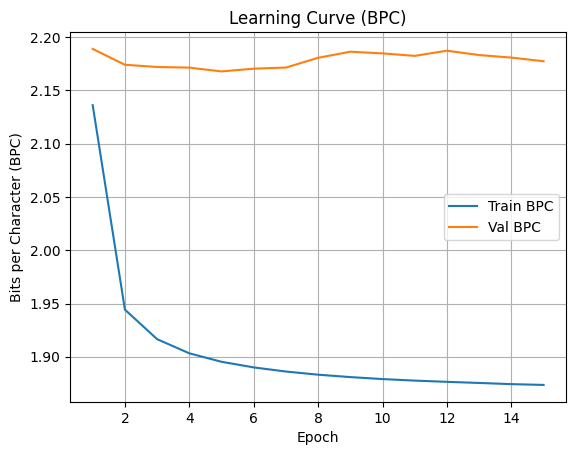

In [10]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_bpcs_lstm, label="Train BPC")
plt.plot(epochs, val_bpcs_lstm, label="Val BPC")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Learning Curve (BPC)")
plt.legend()
plt.grid(True)
plt.show()

### (3) training error rate (RNN w/ LSTM)

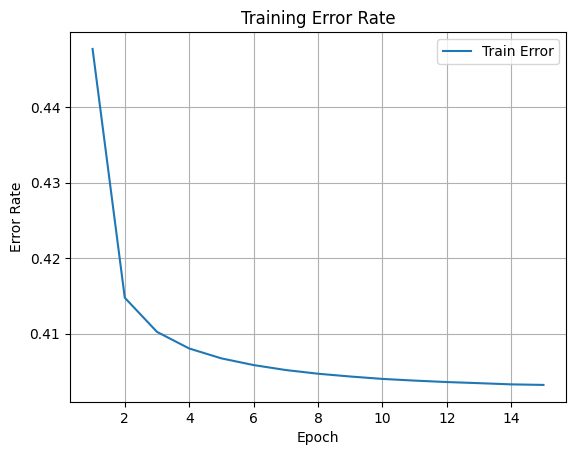

In [11]:
plt.figure()
plt.plot(epochs, train_errors_lstm, label="Train Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Training Error Rate")
plt.legend()
plt.grid(True)
plt.show()

### (4) validation error rate (RNN w/ LSTM)

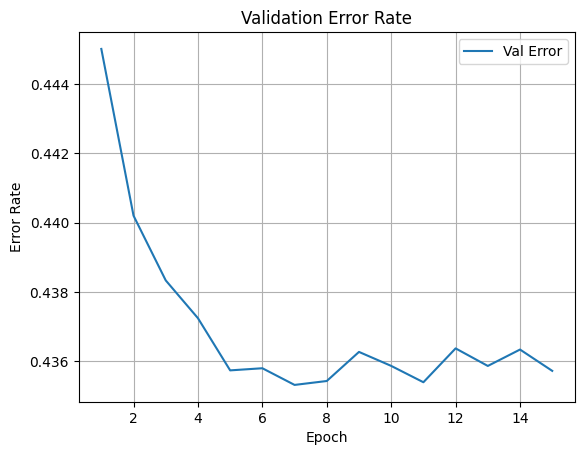

In [12]:
plt.figure()
plt.plot(epochs, val_errors_lstm, label="Val Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Validation Error Rate")
plt.legend()
plt.grid(True)
plt.show()

#### Discuss the differences in the results between the standard RNN and LSTM.
- **LSTM achieves significantly lower training BPC than the standard RNN**
  - the RNN saturates around 2.13 BPC, the LSTM continues to improve and reaches approximately 1.88 BPC.
  - This indicates that LSTM has higher model capacity
- **LSTM also achieves much lower validation BPC, showing better generalization**
  - This indicates that LSTM exhibits superior generalization capability

### (5) Choose 5 breakpoints during your training process to show how well your network learns through more epochs. Feed some part of your training text into RNN and show the text output. (RNN w/ LSTM)

In [18]:
def generate_text_lstm(model, start_text, gen_len=300):
    model.eval()
    generated = list(start_text)

    # Initialize LSTM hidden states: h and c
    h = torch.zeros(num_layers, 1, hidden_size).to(device)
    c = torch.zeros(num_layers, 1, hidden_size).to(device)

    # Prime the LSTM with the start_text
    input_idx = torch.tensor([[vocab_to_int[c] for c in start_text]], device=device)
    x_onehot = F.one_hot(input_idx, num_classes=vocab_size).float()

    with torch.no_grad():
        logits, (h, c) = model(x_onehot, h, c)

    # generate from the last character
    idx = input_idx[0, -1].item()

    for _ in range(gen_len):
        x = torch.tensor([[idx]], device=device)
        x_onehot = F.one_hot(x, num_classes=vocab_size).float()

        with torch.no_grad():
            logits, (h, c) = model(x_onehot, h, c)

        # greedy sampling
        idx = int(torch.argmax(logits[0, -1]).item())
        generated.append(int_to_vocab[idx])

    return "".join(generated)

In [19]:
prime_text = "ROMEO:"

for e in [1, 4, 8, 12, 15]:
    ckpt = f"lstm_epoch{e}.pth"
    model = CharLSTMOneHot(vocab_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))

    print(f"\n===== Epoch {e} Output =====")
    print(generate_text_lstm(model, prime_text, gen_len=300))


===== Epoch 1 Output =====
ROMEO:
So much a man that she will be so much a man
That she will be so much a man that she shall
be a son of the man of the man of the man
That she will be so much a man that she should
I have a man that she will be so much
That I have seen the state of the state of the
to the state of the state of the s

===== Epoch 4 Output =====
ROMEO:
I will not be so much a son of the state,
And the sense of the season of the state,
And the second hand of the season of them,
That we have a son of the season of them,
That we have a son of the season of them,
That we have a son of the season of them,
That we have a son of the season of them,
That

===== Epoch 8 Output =====
ROMEO:
What shall I stand and see the state of the sea
With the season of the season of the state,
And then the sense of the sea of the sea
With the season of the season of the state,
And then the sense of the sea of the sea
With the season of the season of the state,
And then the sense of the sea of 

#### Discuss the differences in the results between the standard RNN and LSTM 
- **RNN:**
  - produces **rigid, short, and meaningless** loops
  - such as “the strange to the strange to the strange…”
  - This indicates that the model can **only memorize short grams** and fails to build sentence-level structures.
- **RNN w/ LSTM**
  - although still repetitive, **generates longer and thematically consistent variations**
  - such as “the season of the season of the state…” ,and “the strength of the world to thee…”
  - These show **awareness of sentence templates and semantic cohesion**, which standard RNN cannot capture.

### (6) Compare the results of choosing different sizes of hidden states and sequence length by plotting the training loss vs. different parameters. (RNN w/ LSTM)

#### 0. Define the RNN with LSTM function to tidy up the code in this question

In [9]:
def train_lstm(hidden_size, seq_len, batch_size=64, num_layers=1, num_epochs=15, lr=1e-3):
    train_dataset = CharDataset(train_array, seq_len)
    val_dataset   = CharDataset(val_array, seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    #model: RNN with LSTM
    model = CharLSTMOneHot(vocab_size, hidden_size, num_layers).to(device)

    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_bpcs, val_bpcs = [], []
    train_errors, val_errors = [], []

    for epoch in range(1, num_epochs + 1):

        # ---------- Train ----------
        model.train()
        total_bpc = 0.0
        total_tokens = 0
        total_correct = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            x_onehot = F.one_hot(x, num_classes=vocab_size).float()

            # LSTM hidden state
            h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)

            logits, (h_n, c_n) = model(x_onehot, h0, c0)

            ce_loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            bpc = ce_loss / math.log(2.0)

            optimizer.zero_grad()
            bpc.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            num_tokens = x.numel()
            total_bpc += bpc.item() * num_tokens
            total_tokens += num_tokens

            pred = logits.argmax(dim=-1)
            total_correct += (pred == y).sum().item()

        avg_train_bpc = total_bpc / total_tokens
        train_bpcs.append(avg_train_bpc)

        # ---------- Validation ----------
        model.eval()
        val_total_bpc = 0.0
        val_total_tokens = 0
        val_total_correct = 0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                x_onehot = F.one_hot(x, num_classes=vocab_size).float()

                h0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)
                c0 = torch.zeros(num_layers, x.size(0), hidden_size, device=device)

                logits, (h_n, c_n) = model(x_onehot, h0, c0)

                ce_loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                bpc = ce_loss / math.log(2.0)

                num_tokens = x.numel()
                val_total_bpc += bpc.item() * num_tokens
                val_total_tokens += num_tokens

                pred = logits.argmax(dim=-1)
                val_total_correct += (pred == y).sum().item()

        avg_val_bpc = val_total_bpc / val_total_tokens
        val_bpcs.append(avg_val_bpc)

        print(f"Epoch {epoch:02d} | Train BPC {avg_train_bpc:.4f} | Val BPC {avg_val_bpc:.4f}")

    return train_bpcs, val_bpcs, train_errors, val_errors, model


#### Case 1: Fix sequence length, and change the hidden state to 64
- As the result, BPC in `hidden_size=64` converges to about 2.12 ; BPC in `hidden_size=128` converges to about 1.87
- We can speculate a larger hidden size leads to a lower BPC because the hidden state dimension controls the model capacity.

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# hidden size: 64
train_bpcs_64_lstm, val_bpcs_64_lstm, _, _, _ = train_lstm(hidden_size=64, seq_len=100)

Epoch 01 | Train BPC 2.3615 | Val BPC 2.3821
Epoch 02 | Train BPC 2.1821 | Val BPC 2.3589
Epoch 03 | Train BPC 2.1568 | Val BPC 2.3709
Epoch 04 | Train BPC 2.1450 | Val BPC 2.3606
Epoch 05 | Train BPC 2.1379 | Val BPC 2.3585
Epoch 06 | Train BPC 2.1331 | Val BPC 2.3694
Epoch 07 | Train BPC 2.1296 | Val BPC 2.3647
Epoch 08 | Train BPC 2.1267 | Val BPC 2.3689
Epoch 09 | Train BPC 2.1244 | Val BPC 2.3698
Epoch 10 | Train BPC 2.1225 | Val BPC 2.3744
Epoch 11 | Train BPC 2.1210 | Val BPC 2.3759
Epoch 12 | Train BPC 2.1198 | Val BPC 2.3761
Epoch 13 | Train BPC 2.1186 | Val BPC 2.3711
Epoch 14 | Train BPC 2.1177 | Val BPC 2.3784
Epoch 15 | Train BPC 2.1168 | Val BPC 2.3742


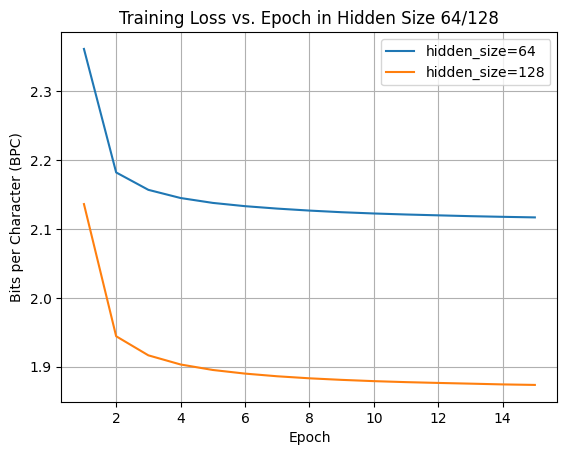

In [22]:
#Compare with hidden size: 64/128
epochs = range(1, 16)

plt.figure()
plt.plot(epochs, train_bpcs_64_lstm,  label="hidden_size=64")
plt.plot(epochs, train_bpcs_lstm, label="hidden_size=128")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Training Loss vs. Epoch in Hidden Size 64/128")
plt.legend()
plt.grid(True)
plt.show()

#### Case 2: Fix the hidden size, and change the Sequence length to 50
- As the result, BPC in `seq_len=50` converges to around 1.94 ; BPC in `seq_len=100` converges to around 1.87
- This shows that using longer context windows allows the RNN to learn more useful dependencies in the text.

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# hidden size: 64
train_bpcs_50_lstm, val_bpcs_50_lstm, _, _, _ = train_lstm(hidden_size=128, seq_len=50)

Epoch 01 | Train BPC 2.2170 | Val BPC 2.2552
Epoch 02 | Train BPC 2.0238 | Val BPC 2.2383
Epoch 03 | Train BPC 1.9948 | Val BPC 2.2295
Epoch 04 | Train BPC 1.9799 | Val BPC 2.2324
Epoch 05 | Train BPC 1.9706 | Val BPC 2.2318
Epoch 06 | Train BPC 1.9642 | Val BPC 2.2353
Epoch 07 | Train BPC 1.9595 | Val BPC 2.2369
Epoch 08 | Train BPC 1.9560 | Val BPC 2.2411
Epoch 09 | Train BPC 1.9533 | Val BPC 2.2369
Epoch 10 | Train BPC 1.9510 | Val BPC 2.2381
Epoch 11 | Train BPC 1.9491 | Val BPC 2.2367
Epoch 12 | Train BPC 1.9475 | Val BPC 2.2450
Epoch 13 | Train BPC 1.9462 | Val BPC 2.2413
Epoch 14 | Train BPC 1.9449 | Val BPC 2.2255
Epoch 15 | Train BPC 1.9436 | Val BPC 2.2256


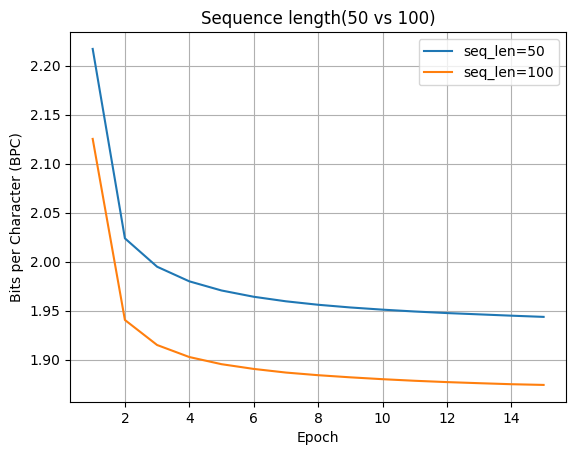

In [15]:
# Compare with seq_len: 50/100
epochs = range(1, 16)

plt.figure()
plt.plot(epochs, train_bpcs_50_lstm,  label="seq_len=50")
plt.plot(epochs, train_bpcs_lstm, label="seq_len=100")
plt.xlabel("Epoch")
plt.ylabel("Bits per Character (BPC)")
plt.title("Sequence length(50 vs 100)")
plt.legend()
plt.grid(True)
plt.show()

#### Discuss the differences in the results between the standard RNN and LSTM
- As the result, we can realize that both have the same conclusion: a larger `seq_len` and a bigger `hidden_size` can lead to a better result (lower BPC)
- The difference in both RNN and RNN w/ LSTM is the latter has a lower BPC no matter in training and validation


##  5. Use RNN or LSTM to generate some words by priming the model with a word related to your dataset.
- Priming the model means giving it some input text to create context and then take the output of the RNN.
- For example, use ”JULIET” as the prime text of Shakespeare dataset and run the model to generate 10 to 15 lines of output.

In [56]:
prime_text = "JULIET:"
model.load_state_dict(torch.load("lstm_epoch15.pth", map_location=device))
print(generate_text_lstm(model, prime_text, gen_len=500))

JULIET:
I will not be a stranger to the streets.

CASSIUS:
I will not be a stars and the streets,
And the sun and the streets of the world and the
short and the streets of the strength of the world,
And the man is the stranger than the world.

CASSIUS:
I will not be a stars and the streets,
And the sun and the streets of the world and the
short and the streets of the strength of the world,
And the man is the stranger than the world.

CASSIUS:
I will not be a stars and the streets,
And the sun and the s


- **Conclusion:**
The generated text roughly follows the dialogue style of Shakespeare’s plays (character names like JULIET, CASSIUS, etc.), but it still tends to repeat certain phrases such as “the streets of the world” because the model is a small 1-layer LSTM with limited capacity and we use greedy decoding.